In [4]:
import torch
import networkx as nx
from torch.utils.data import Dataset, DataLoader
import numpy as np 
from sklearn.metrics import r2_score 


import sys 
sys.path.append('../src/')

from src.models.GSNN import GSNN
from src.data.LincsDataset import LincsDataset

%load_ext autoreload
%autoreload 2

In [50]:
# edge id -->               0  1  2  3  4  5  6
edge_index = torch.tensor([[0, 1, 2, 3, 2, 2, 3],
                           [1, 2, 1, 1, 3, 4, 5]], dtype=torch.long)

E = edge_index.size(1)

# only node 0 is input node 
input_node_mask = torch.tensor([True, False, False, False, False, False])

# nodes 4,5 are output nodes 
output_node_mask = torch.tensor([False, False, False, False, True, True])

# shape (B, E)
# NOTE: represents NODE inputs 
x =  torch.tensor([[1., 0., 0., 0.,0.,0.],
                    [-1., 0., 0., 0.,0.,0.]]) 

B = x.size(0)
N = torch.unique(edge_index).view(-1).size(0)

# NOTE: node attrs are now handled by additional input nodes. 

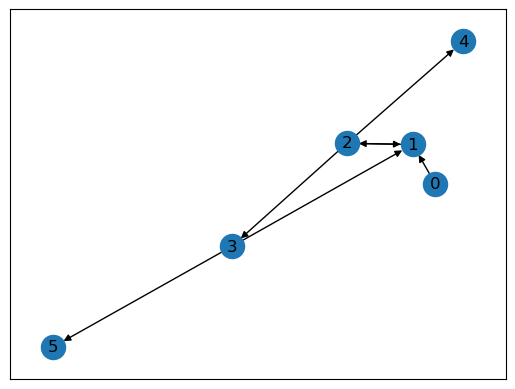

In [51]:
E = (E.detach().cpu().numpy().tolist() for E in edge_index.T)
G = nx.DiGraph(E)

nx.draw_networkx(G)

In [52]:
def get_W1_indices(edge_index, channels): 
    '''
    # how to create input layer , e.g., edge values -> node indices 

    # for edge in edge index 
        # for k in channels 
            #  add weight indice:    (edge_id, node_id + k)
    '''
    row = [] 
    col = []
    for edge_id, (src, dst) in enumerate(edge_index.detach().cpu().numpy().T):
        for k in range(channels): 
            row.append(edge_id)
            col.append(dst.item() + k)

    row = torch.tensor(row, dtype=torch.float32)
    col = torch.tensor(col, dtype=torch.float32)
    indices = torch.stack((row,col), dim=0)
    return indices


def get_W2_indices(function_nodes, channels): 
    '''
    # how to create node -> node latent weight indices 

    # for node_id in function_nodes 
        # for k in channels: 
            # for k2 in channels: 
                # add weight indice: (node_id + k, node_id + k2)
    '''
    row = []
    col = []
    for node_id in function_nodes: 
        for k in range(channels): 
            for k2 in range(channels): 
                row.append(node_id.item() + k)
                col.append(node_id.item() + k2)

    row = torch.tensor(row, dtype=torch.float32)
    col = torch.tensor(col, dtype=torch.float32)
    indices = torch.stack((row,col), dim=0)
    return indices

def get_W3_indices(edge_index, function_nodes, channels): 
    '''
    # how to create node -> edge indices 

    # for node_id in function_nodes 

        # filter to edges from node_id 
        # src, dst = edge_index
        # out_edges = (src == node_id).nonzero()
        # for k in channels: 
            # for out_edge_idx in out_edges: 
                # add weight indice:   (node_id + k, out_edge_idx)
    '''
    row = [] 
    col = []
    for node_id in function_nodes: 
        
        src,dst = edge_index 
        out_edges = (src == node_id).nonzero(as_tuple=True)[0]

        for k in range(channels):
            
            for edge_id in out_edges: 

                row.append(node_id.item() + k)
                col.append(edge_id.item())

    row = torch.tensor(row, dtype=torch.float32)
    col = torch.tensor(col, dtype=torch.float32)
    indices = torch.stack((row,col), dim=0)
    return indices

def node2edge(x, edge_index): 
    '''
    convert from node indexed attributes to edge indexed attributes
    '''
    src,dst = edge_index 
    return x[src] 

def edge2node(x, edge_index, output_node_mask): 
    ''' 
    convert from edge indexed attributes `x` to node indexed attributes
    NOTE: only maps to output nodes (eg., in-degree = 1) to avoid collisions; all other nodes (input nodes + function nodes) will have value of 0. 
    '''
    output_nodes = output_node_mask.nonzero(as_tuple=True)[0]
    src, dst = edge_index 
    output_edge_mask = torch.isin(dst, output_nodes)

    out = torch.zeros(output_node_mask.size(0), dtype=torch.float32, device=x.device)
    out[dst[output_edge_mask]] = x[output_edge_mask]

    return out



In [64]:
class SparseLinear(torch.nn.Module): 
    def __init__(self, indices, dtype=torch.float32):
        '''
        indices: COO format 

        TODO: initialization values xavier ...  
        '''
        super().__init__() 

        src, dst = indices 
        self.weight = torch.nn.Parameter(torch.sparse_coo_tensor(indices=indices, values=torch.randn(indices.size(1), dtype=dtype)))
        self.bias = torch.nn.Parameter(torch.zeros((len(dst),), dtype=dtype))

    def forward(self, x): 

        print(x.size())
        print(self.weight.size())

        return torch.sparse.mm(self.weight, x) + self.bias

    

In [77]:
class GSNN(torch.nn.Module): 

    def __init__(self, edge_index, channels, input_node_mask, output_node_mask, layers, nonlin=torch.nn.ELU): 
        super().__init__()

        self.layers = layers 
        self.edge_index = edge_index
        function_nodes = (~(input_node_mask | output_node_mask)).nonzero(as_tuple=True)[0]

        print(function_nodes)

        self.lin1 = SparseLinear(indices=get_W1_indices(edge_index, channels))
        self.lin2 = SparseLinear(indices=get_W2_indices(function_nodes, channels))
        self.lin3 = SparseLinear(indices=get_W3_indices(edge_index, function_nodes, channels))

        self.nonlin = nonlin() 

    def forward(self, x):
        '''
        x is `node` indexed 
        ''' 
        x0 = node2edge(x, edge_index) 
        x = x0

        for l in range(self.layers): 

            x = self.lin1(x)
            print('1', x.size())
            print('1 type', x)
            x = self.nonlin(x)
            x = self.lin2(x)
            print('2', x.size())
            x = self.nonlin(x)
            x = self.lin3(x) 
            print('3', x.size())
            x = x + x0

        x = edge2node(x, edge_index)
        return x 



In [78]:
model = GSNN(edge_index, channels=2, input_node_mask=input_node_mask, output_node_mask=output_node_mask, layers=3)

tensor([1, 2, 3])


In [79]:
model(x[0, :].unsqueeze(-1))

torch.Size([7, 1])
torch.Size([7, 7])
1 torch.Size([7, 14])
1 type 

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       grad_fn=<AddBackward0>)
torch.Size([7, 14])
torch.Size([5, 5])


RuntimeError: addmm: Argument #3 (dense): Expected dim 0 size 5, got 7

In [63]:
x.shape

torch.Size([2, 6])